## Distance Matrix Calculation
### Objetive: Given a Shapefile with Form and Subsections, generate a Distance Matrix 

In [1]:
# list of imports
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from multiprocessing import Pool
from functools import partial
import numpy as np
from shapely.geometry import Point

In [2]:
# Load Necessary Data

# Load data Polygons 
polygons = gpd.read_file('./data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp', dtype={'BGRI11': str})

# Add a column with all centroids
# polygons = polygons.to_crs({'init': 'epsg:4326'})
# polygons['sCentroid'] = polygons.centroid

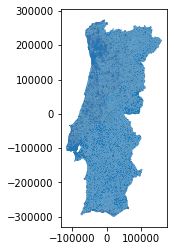

In [3]:
polygons.plot()

In [4]:
# Load School Data - This is the old File
# schools = gpd.read_file('../optimization/data_gettin/escolasourem/gdf_escolas_Ourem2019_capacidades.shp')

# Load School Data
schools = gpd.read_file('../optimization/data_gettin/escolasourem/gdf_escolas_Ourem2019_capacidades.shp')

In [5]:
# schools.index = schools.FID
# schools = schools.drop(columns=['FID', 'id'])
schools = schools.to_crs({'init': 'epsg:4326'})

In [6]:
def select_shape(column, value, polygons):
    # Load BGRI-2011 Data
    polygons = polygons[polygons[column]==value]
    shape_df = polygons.dissolve(by=column, as_index=False)
    return shape_df

In [7]:
def get_network(shape_dataFrame):
    latlng_geom, _ = ox.project_geometry(shape_dataFrame.geometry[0], crs={'init':'epsg:3763'}, to_latlong=True)
    network = ox.graph_from_polygon(latlng_geom, network_type='all_private')
    return network

In [8]:
def calculate_distance(point1, point2):

    node1 = ox.utils.get_nearest_node(myNetwork, (point1.y, point1.x))
    node2 = ox.utils.get_nearest_node(myNetwork, (point2.y, point2.x))
    try:
        distance = nx.shortest_path_length(myNetwork, node1, node2, weight='length')
    except Exception as ex:
        print('Node {} not reachable from {}'.format(point1, point2))
        print(ex)
        distance = float('NaN')
    return distance

In [9]:
def parallelize(data, func, num_of_processes=7):

    pool = Pool(num_of_processes)
    # This will concat the operation with the iterable itens from data_split
    listOfBgri = list(data[['from', 'to']].itertuples(index=True, name=None))
    data_split = np.array_split(listOfBgri, num_of_processes)
#     data = pd.concat(pool.map(func, data_split))
#     print(data_split[0])

    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=7):
    return parallelize(data, partial(run_calculation, func), num_of_processes)

def run_calculation(func, points):
    index = []
    values = []
 
    # FIZ UMA ALTERAÇAO TEMPORARIA AQUI NA LINHA 28. TROQUEI PARA ESCOLAS PARA VER SE O RESULTADO SAIA
    # TO-DO: Criar uma rotina para verificar qual tipo de ponto de entrada está sendo submetido.
    for e in points:
        index.append(int(e[0]))
        values.append(calculate_distance(schools.iloc[int(e[1])].geometry, bgri.loc[e[2]].geometry))
    partialDistances = pd.Series(values, index=index) 
    return partialDistances

In [10]:
def create_distance_matrix(bgri_df):
    pairwise = pd.DataFrame(columns = bgri_df.index, index = bgri_df.index)
    long_form = pairwise.unstack()
    long_form.index.rename(['from', 'to'], inplace=True)
    long_form = long_form.to_frame('real_distance').reset_index()
    # ---- Multiprocess ----
    long_form['real_distance'] = parallelize_on_rows(long_form, calculate_distance)
    return long_form

In [11]:
def create_distance_matrix_to_sig(bgri_df, sig_gdf):
    pairwise = pd.DataFrame(columns = sig_gdf.index, index = bgri_df.index)
    long_form = pairwise.unstack()
    long_form.index.rename(['from', 'to'], inplace=True)
    long_form = long_form.to_frame('real_distance').reset_index()
    # ---- Multiprocess ----
    long_form['real_distance'] = parallelize_on_rows(long_form, calculate_distance)
    return long_form

In [12]:
# List of Globals

# BGRI for the selected Place
bgri = polygons[polygons['DTMN11']=='1421'].to_crs({'init': 'epsg:4326'})
bgri['geometry'] = bgri.centroid
bgri.index = bgri.BGRI11


In [13]:
polygons

,OBJECTID,DTMN11,FR11,SEC11,SS11,BGRI11,LUG11,LUG11DESIG,area,geometry
0,548,0407,02,001,04,04070200104,013810,Abreiro,0.114464,"POLYGON ((70385.364 187253.985, 70468.973 1871..."
1,549,0407,02,001,06,04070200106,013810,Abreiro,0.054224,"POLYGON ((70345.582 187206.405, 70365.695 1871..."
2,550,0407,02,001,01,04070200101,013811,Milhais,0.066225,"POLYGON ((67451.278 188137.559, 67436.483 1881..."
3,551,0407,02,001,02,04070200102,013811,Milhais,0.130057,"POLYGON ((67881.058 188228.057, 67897.728 1882..."
4,552,0407,29,001,03,04072900103,013866,Pai Torto,0.067553,"POLYGON ((71675.138 205540.515, 71691.487 2055..."
...,...,...,...,...,...,...,...,...,...,...
255839,0,0101,01,001,15,01010100115,014426,Lomba,0.109663,"POLYGON ((-15277.170 96771.640, -15281.176 967..."
255840,0,0101,01,001,14,01010100114,014428,Vila Mendo,0.056414,"POLYGON ((-15422.652 97179.651, -15426.911 971..."
255841,0,0101,01,001,01,01010100101,014420,Alcafaz,0.181161,"POLYGON ((-16197.871 101120.085, -16197.873 10..."
255842,0,0101,01,001,10,01010100110,014422,Foz,0.162631,"POLYGON ((-15983.302 98000.233, -15986.565 979..."


In [14]:
shape_df = select_shape('DTMN11', '1421', polygons)

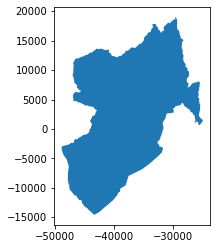

In [15]:
shape_df.plot()

In [16]:
myNetwork = get_network(shape_df)

In [17]:
shape_df = shape_df.to_crs({'init': 'epsg:4326'})

In [18]:
# points = bgri.loc[['09031600206', '09031600201']]
# base = bgri.plot()
# points.plot(ax=base, marker='o', color='red', markersize=5);

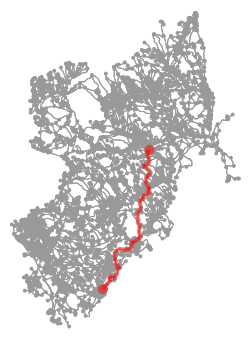

(<Figure size 406.759x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1a29bd37f0>)

In [36]:
# Get two Points from BGRI and show the shortest path between then

node1 = ox.utils.get_nearest_node(myNetwork, (bgri.iloc[2].geometry.y, bgri.iloc[2].geometry.x), method='euclidean')

node2 = ox.utils.get_nearest_node(myNetwork, (bgri.iloc[1000].geometry.y, bgri.iloc[1000].geometry.x), method='euclidean')

route = nx.shortest_path(myNetwork, node1, node2)
ox.plot_graph_route(myNetwork, route)

In [37]:
# How to plot points using the polygons as base

# points = bgri.loc[['09031700111', '09030700125']]
# base = polygons[polygons['DTMN11']=='0903'].to_crs({'init': 'epsg:4326'}).plot()
# points.plot(ax=base, marker='o', color='red', markersize=5);

In [21]:
result = create_distance_matrix(bgri.head(2))

IndexError: single positional indexer is out-of-bounds

In [41]:
# Get the distance between two points - These two are some how disconected
point1 = Point(-7.313499936901444, 40.64471169382188)
point2 = Point(-7.411244264833021, 40.65630294536609)
calculate_distance(point1,point2)

0

In [42]:
polygons.centroid

0          POINT (70250.774 187367.022)
1          POINT (70289.266 187137.974)
2          POINT (67325.763 188069.355)
3          POINT (67586.273 188073.091)
4          POINT (71555.623 205480.006)
                      ...              
255839     POINT (-15270.344 97095.131)
255840     POINT (-15673.692 97209.760)
255841    POINT (-16108.927 100849.486)
255842     POINT (-16230.798 97886.264)
255843     POINT (-15955.290 98183.825)
Length: 255844, dtype: geometry

In [21]:
# Save Result to CSV
result.to_csv('./data/distancematrix-0903.csv')


In [87]:
result = create_distance_matrix(bgri.head(2))

['2' '14210400209' '14210400421']
['3' '14210400209' '14210400209']
['0' '14210400421' '14210400421']
['1' '14210400421' '14210400209']


In [22]:
# Calculate the Distance Matrix for the BGRI and The Given Sig data - Schools
result = create_distance_matrix_to_sig(bgri, schools)

In [23]:
result.rename(columns={'from':'origin'}, inplace=True)

In [28]:
result = pd.merge(result, 
                  schools[['Nome_Escol', 'FID_x','Capacidade', 'Capacida_1', 'Capacida_2','Capacida_3','Capacida_4','geometry']],
                  how='left', left_on=[result.origin], right_on=[schools.index])

In [29]:
result.drop(columns='key_0', inplace=True)

In [30]:
result.to_csv('./data/distance_matrix_schools_ourem.csv')

In [31]:
result.shape

(74334, 11)

In [27]:
schools

,id,FID_x,Elegiveis_,Nome_Escol,Codigo_DGE,Salas_Pre_,Salas_1CEB,Salas_2CEB,Salas_3CEB,Salas_Sec,...,Alunos_1CE,Alunos_2CE,Alunos_3CE,Alunos_Sec,Capacidade,Capacida_1,Capacida_2,Capacida_3,Capacida_4,geometry
0,247,0,1,1 - EB da Cova da Iria (JI/EB1),1421416,4,8,0,0,0,...,187,0,0,0,100,192,0,0,0,POINT (-8.68141 39.63732)
1,261,1,1,17 - EB Ourém Nascente (JI/EB1),1421004,3,4,0,0,0,...,53,0,0,0,75,96,0,0,0,POINT (-8.51813 39.65917)
2,262,2,1,2 - EB do Olival (JI/EB1),1421752,3,4,0,0,0,...,46,0,0,0,75,96,0,0,0,POINT (-8.60508 39.71654)
3,0,3,1,23 - EB de Urqueira Norte (JI/EB1),1421904,1,2,0,0,0,...,17,0,0,0,25,48,0,0,0,POINT (-8.58546 39.75161)
4,0,4,1,24 - EB da Carvoeira (JI/EB1),1421643,3,4,0,0,0,...,76,0,0,0,75,96,0,0,0,POINT (-8.54190 39.71774)
5,0,5,1,3 - JI do Bairro (JI),1421699,2,0,0,0,0,...,0,0,0,0,50,0,0,0,0,POINT (-8.59183 39.57334)
6,0,6,1,"30 - EB Cónego Dr. Manuel Lopes Perdigão (EB2,3)",1421966,0,0,7,10,0,...,0,93,121,0,0,0,196,280,0,POINT (-8.54396 39.72022)
7,0,8,1,26 - EB de Espite (JI/EB1),1421405,2,2,0,0,0,...,20,0,0,0,50,48,0,0,0,POINT (-8.63802 39.76425)
8,0,10,1,4 - EB de Matas (Pisão) (JI/EB1),1421145,2,2,0,0,0,...,25,0,0,0,50,48,0,0,0,POINT (-8.66695 39.74373)
9,0,11,1,27 - EB de Rio de Couros (JI/EB1),1421664,2,2,0,0,0,...,29,0,0,0,50,48,0,0,0,POINT (-8.49678 39.72829)
